## Data preprocessing

### Generator Class
  - Encapsulates various financial technical analysis methods designed to calculate technical indicators from financial data.

**Technical indicators extracted**
  - **Simple Moving Average (SMA)**: Calculates the average of the data over a specified window size by creating a constantly updated average price.
  - **Exponential Moving Average (EMA)**: Similar to SMA, but gives more weight to recent data, making it more responsive to new information. The windows parameter defines the span of the EMA.
  - **Moving Average Convergence Divergence (MACD)**: Calculates the MACD line as the difference between two EMAs (short and long-term), then the signal line as an EMA of the MACD line. Used to identify trend direction and reversals.
  - **Relative Strength Index (RSI)**: Momentum oscillator measuring speed and change of price movements. It scillates 0-100, typically used to identify overbought or oversold conditions.
  - **Average True Range (ATR)**: Measures market volatility, decomposing the entire range of an asset price for that period. Useful for stop-loss order placement.
  - **Bollinger Bands**: Volatility bands are placed above and below a moving average. Volatility is based on the standard deviation and bands automatically widen when volatility increases and narrow when volatility decreases.
  - **Raw Stochastic Value (RSV)**: Component of the Stochastic Oscillator, a momentum indicator comparing a particular closing price of an asset to a range of its prices over a certain period. RSV is calculated without the smoothing factors applied in the full Stochastic Oscillator formula.

In [ ]:
# Generator Class
class Generator():
    def __init__(self):
        pass

    def SMA(self, data, windows):
        res = data.rolling(window = windows).mean()
        return res

    def EMA(self, data, windows):
        res = data.ewm(span = windows).mean()
        return res

    def MACD(self, data, long, short, windows):
        short_ = data.ewm(span = short).mean()
        long_ = data.ewm(span = long).mean()
        macd_ = short_ - long_
        res = macd_.ewm(span = windows).mean()
        return res

    def RSI(self, data, windows):
        delta = data.diff(1)
        up = delta.copy()
        down = delta.copy()
        up[up < 0] = 0
        down[down > 0] = 0
        avg_up = up.rolling(window = windows).mean()
        avg_down = down.rolling(window = windows).mean()
        rs = avg_up/ avg_down
        rsi = 100. -(100./ (1. + rs))
        return rsi

    def atr(self, data_high, data_low, windows):
        range_ = data_high - data_low
        res = range_.rolling(window = windows).mean()
        return res

    def bollinger_band(self, data, windows):
        sma = data.rolling(window = windows).mean()
        std = data.rolling(window = windows).std()
        upper = sma + 2 * std
        lower = sma - 2 * std
        return upper, lower

    def rsv(self, data, windows):
        min_ = data.rolling(window = windows).min()
        max_ = data.rolling(window = windows).max()
        res = (data - min_)/ (max_ - min_) * 100
        return res

### Libraries of note

**pandas_datareader**: Tool for reading data into pandas DataFrames directly from various internet sources, typically used for fetching financial data.

**yfinance**: Open-source library that uses the Yahoo Finance API to fetch historical market data.

In [ ]:
# Uncomment out these commands to install the libraries not native to Google Colab
#!pip install pandas_datareader
#!pip install yfinance
#!pip install keras-tuner
#!pip install h2o

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as web
import datetime as dt
import yfinance as yf
import math
import h2o
from h2o.automl import H2OAutoML

from kerastuner.tuners import BayesianOptimization
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout, TimeDistributed, Reshape, Bidirectional, BatchNormalization, Attention
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.regularizers import l1_l2

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer

<ipython-input-3-3ca03fd5366d>:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


### Data Collection

We define the start and end dates for the period over which financial data will be fetched. Yahoo only contains histrorical price data from as far back as November 2017. This is ideal because including data prior to 2018 would be nonsensical due to the price action not being relevant to today.

In [ ]:
end = dt.datetime(2024,2,2)
start = dt.datetime(2017,11,11)
start, end

(datetime.datetime(2017, 11, 11, 0, 0), datetime.datetime(2024, 2, 2, 0, 0))

**`yf.pdr_override()`** ensures that `yfinance` capabilities enhance the data fetching process,
providing a seamless way to access and utilize Yahoo Finance data through pandas_datareader.
It is designed to allow users to use `yfinance`' more robust methods for fetching data
while maintaining the familiar interface of `pandas_datareader`.
It 'overrides' certain methods in pandas_datareader with those from `yfinance`, combining
the best of both. The data fetching capabilities of yfinance and the straightforward, DataFrame-oriented syntax of `pandas_datareader`.

When calling `yf.pdr_override()`, `yfinance` intercepts calls made to pandas_datareader's
`get_data_yahoo` (and potentially other functions) and reroutes them through yfinance's
mechanisms for fetching data. This means that even though we're using pandas_datareader's
function calls in your code, the actual data retrieval is handled by `yfinance`, benefiting
from its enhanced handling of Yahoo Finance's data, including any fixes for issues like
rate limits, missing data, or API changes.

The resulting **'data'** DataFrame contains financial information about the digital asset, such as
open, high, low, close prices, and volume for each trading day within the specified period,
which can be used for further analysis or modeling. ​

In [ ]:
eth = ['ETH-USD']
yf.pdr_override()
data = web.get_data_yahoo(eth, start, end)

[*********************100%%**********************]  1 of 1 completed


This section of code is designed to fetch historical data for a predefined list of digital assets. Next we will calculate various financial indicators for each, manipulate and analyze the data using Fast Fourier Transform (FFT) techniques.

In [ ]:
crypto_tickers = [
    "BTC-USD",  # Bitcoin
    "BNB-USD",  # BNB
    "SOL-USD",  # Solana
    "XRP-USD",  # XRP
    "STETH-USD",# Lido Staked ETH
    "ADA-USD",  # Cardano
    "DOGE-USD", # Dogecoin
    "SHIB-USD", # Shiba Inu
    "AVAX-USD", # Avalanche
    "DOT-USD",  # Polkadot
    "WTRX-USD", # Wrapped TRON
    "TRX-USD",  # TRON
    "LINK-USD", # Chainlink
    "MATIC-USD",# Polygon
    "WBTC-USD", # Wrapped Bitcoin
    "TON11419-USD", # Toncoin
    "BCH-USD",  # Bitcoin Cash
    "UNI7083-USD",# Uniswap
    "LTC-USD",  # Litecoin
    "ICP-USD",  # Internet Computer
    "DAI-USD",  # Dai
    "FIL-USD"   # Filecoin
]


### Feature Extraction

**Technical Indicators Calculation**

Various technical indicators are calculated for each cryptocurrency using both custom methods defined in the Generator class and direct calculations:

- Percentage Change and Log Change: Daily percentage and logarithmic price
changes are calculated to measure volatility and price movement direction.

- Exponential Moving Averages (EMA): EMAs for 7, 14, and 21-day periods are calculated to identify trends.

- Moving Average Convergence Divergence (MACD): MACD values for specified periods are calculated to detect changes in momentum.

- Relative Strength Index (RSI): RSI for 7, 14, and 21-day periods are calculated to identify overbought or oversold conditions.

- Average True Range (ATR): ATR for 7, 14, and 21-day periods are calculated to measure market volatility.

- Bollinger Bands: Bollinger Bands for 7, 14, and 21-day periods are calculated to provide insights into price volatility and potential price targets.

- Raw Stochastic Value (RSV): RSV for 7, 14, and 21-day periods are calculated to identify potential buy or sell signals.
Fast Fourier Transform (FFT) Analysis

- FFT Transformation: The code performs FFT on the closing prices of each cryptocurrency to identify underlying trends not immediately apparent in the time domain. FFT transforms time-domain data (like daily closing prices) into the frequency domain, helping to highlight cycles or repetitive patterns in price movements.

**Components Isolation**

The code isolates specific components (frequencies) from the FFT result to focus on significant trends by zeroing out other components. Several components are selected (15, 27, 81, 100), and inverse FFT is applied to convert these isolated frequency-domain data back into the time domain, allowing the identification of major trends affecting the asset's price.

**Data Manipulation**

The column names in the data frame are renamed to include the ticker for clarity and all the modified data frames are concatenated into a single data frame. This enables easy comparison and analysis across different assets.

In [ ]:
df = {}
Generator = Generator()
for ticker in crypto_tickers:
    yf.pdr_override()
    df[ticker] = web.get_data_yahoo(eth, start, end)
    df[ticker]['pct_change'] = (df[ticker]['Close'] - df[ticker]['Close'].shift(1))/ df[ticker]['Close'].shift(1)
    df[ticker]['log_change'] = np.log(df[ticker]['Close']/ df[ticker]['Close'].shift(1))

    df[ticker]['7ma'] = Generator.EMA(df[ticker]['Close'], 7)
    df[ticker]['14ma'] = Generator.EMA(df[ticker]['Close'], 14)
    df[ticker]['21ma'] = Generator.EMA(df[ticker]['Close'], 21)
    df[ticker]['7macd'] = Generator.MACD(df[ticker]['Close'], 3, 11, 7)
    df[ticker]['14macd'] = Generator.MACD(df[ticker]['Close'], 7, 21, 14)
    df[ticker]['7rsi'] = Generator.RSI(df[ticker]['Close'], 7)
    df[ticker]['14rsi'] = Generator.RSI(df[ticker]['Close'], 14)
    df[ticker]['21rsi'] = Generator.RSI(df[ticker]['Close'], 21)
    df[ticker]['7atr'] = Generator.atr(df[ticker]['High'], df[ticker]['Low'], 7)
    df[ticker]['14atr'] = Generator.atr(df[ticker]['High'], df[ticker]['Low'], 14)
    df[ticker]['21atr'] = Generator.atr(df[ticker]['High'], df[ticker]['Low'], 21)
    df[ticker]['7upper'], df[ticker]['7lower'] = Generator.bollinger_band(df[ticker]['Close'], 7)
    df[ticker]['14upper'], df[ticker]['14lower'] = Generator.bollinger_band(df[ticker]['Close'], 14)
    df[ticker]['21upper'], df[ticker]['21lower'] = Generator.bollinger_band(df[ticker]['Close'], 21)
    df[ticker]['7rsv'] = Generator.rsv(df[ticker]['Close'], 7)
    df[ticker]['14rsv'] = Generator.rsv(df[ticker]['Close'], 14)
    df[ticker]['21rsv'] = Generator.rsv(df[ticker]['Close'], 21)

    close_fft = np.fft.fft(np.asarray(df[ticker]['Close'].tolist()))
    fft_df = pd.DataFrame({'fft':close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
    fft_list = np.asarray(fft_df['fft'].tolist())
    for num_ in [15, 27, 81, 100]:
        fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_] = 0
        df[ticker][f'FT_{num_}components'] = np.fft.ifft(fft_list_m10)
    df[ticker]['FT_3components'] = df[ticker]['FT_3components'].astype('float')
    df[ticker]['FT_6components'] = df[ticker]['FT_6components'].astype('float')
    df[ticker]['FT_9components'] = df[ticker]['FT_9components'].astype('float')
    df[ticker]['FT_27components'] = df[ticker]['FT_27components'].astype('float')
    df[ticker]['FT_81components'] = df[ticker]['FT_81components'].astype('float')
    df[ticker]['FT_100components'] = df[ticker]['FT_100components'].astype('float')

    # Rename columns
    renamed_columns = {col: f'{col}_{ticker}' for col in df[ticker].columns}
    df[ticker].rename(columns=renamed_columns, inplace=True)
    data = pd.concat([data, df[ticker]], axis=1)

[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=Tr

In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,Open_BTC-USD,High_BTC-USD,Low_BTC-USD,Close_BTC-USD,...,21lower_FIL-USD,7rsv_FIL-USD,14rsv_FIL-USD,21rsv_FIL-USD,FT_3components_FIL-USD,FT_6components_FIL-USD,FT_9components_FIL-USD,FT_27components_FIL-USD,FT_81components_FIL-USD,FT_100components_FIL-USD
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992,298.585999,319.453003,298.191986,314.681000,...,NaN,NaN,NaN,NaN,1383.839201,1421.197402,1516.615919,1330.886933,1226.731679,1159.053772
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936,314.690002,319.153015,298.513000,307.907990,...,NaN,NaN,NaN,NaN,1381.159669,1416.105437,1508.239409,1283.737377,1090.083904,999.236983
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984,307.024994,328.415009,307.024994,316.716003,...,NaN,NaN,NaN,NaN,1378.463980,1410.999468,1499.805532,1237.044187,958.416422,850.310227
2017-11-14,316.763000,340.177002,316.763000,337.631012,337.631012,1069680000,316.763000,340.177002,316.763000,337.631012,...,NaN,NaN,NaN,NaN,1375.752209,1405.879732,1491.316031,1190.920196,833.701446,715.325269
2017-11-15,337.963989,340.911987,329.812988,333.356995,333.356995,722665984,337.963989,340.911987,329.812988,333.356995,...,NaN,NaN,NaN,NaN,1373.024431,1400.746468,1482.772669,1145.476644,717.730219,596.694220


We add two new columns to the data DataFrame, representing different ways to calculate the rate of return for the price data.

**Percentage Change (pct_change)**
  - Difference between the current and previous day's closing prices, divided by the previous day's closing price. It represents the daily return as a percentage and is a common way to analyze price movements in financial data.

  - `data['pct_change'] = (data['Close'] - data['Close'].shift(1)) / data['Close'].shift(1)`, calculates the percentage change for each row in the DataFrame (except the first one, which will be NaN since there's no previous data point). The `.shift(1)` method is used to access the previous row's Close value.

**Logarithmic Change (log_change)**
  - Calculates the natural logarithm of the ratio between the current and previous day's closing prices.
  - Logarithmic returns are useful for various financial analyses because they are additive over time and can handle negative price changes more refined than percentage changes.
  - `data['log_change'] = np.log(data['Close'] / data['Close'].shift(1))`, similar to the percentage change, but this time it's the log of the ratio of the closing prices. The logarithmic return for each day is computed, with the first entry also being NaN for the same reason as above.

In [ ]:
data['pct_change'] = (data['Close'] - data['Close'].shift(1))/ data['Close'].shift(1)
data['log_change'] = np.log(data['Close']/ data['Close'].shift(1))

<ipython-input-9-0b6cc8345016>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['pct_change'] = (data['Close'] - data['Close'].shift(1))/ data['Close'].shift(1)
<ipython-input-9-0b6cc8345016>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['log_change'] = np.log(data['Close']/ data['Close'].shift(1))


Technical Calcualations are now performed on the ETH '`data`' dataframe.

In [ ]:
data['7ma'] = Generator.EMA(data['Close'], 7)
data['14ma'] = Generator.EMA(data['Close'], 14)
data['21ma'] = Generator.EMA(data['Close'], 21)
data['7macd'] = Generator.MACD(data['Close'], 3, 11, 7)
data['14macd'] = Generator.MACD(data['Close'], 7, 21, 14)
data['7rsi'] = Generator.RSI(data['Close'], 7)
data['14rsi'] = Generator.RSI(data['Close'], 14)
data['21rsi'] = Generator.RSI(data['Close'], 21)
data['7atr'] = Generator.atr(data['High'], data['Low'], 7)
data['14atr'] = Generator.atr(data['High'], data['Low'], 14)
data['21atr'] = Generator.atr(data['High'], data['Low'], 21)
data['7upper'], data['7lower'] = Generator.bollinger_band(data['Close'], 7)
data['14upper'], data['14lower'] = Generator.bollinger_band(data['Close'], 14)
data['21upper'], data['21lower'] = Generator.bollinger_band(data['Close'], 21)
data['7rsv'] = Generator.rsv(data['Close'], 7)
data['14rsv'] = Generator.rsv(data['Close'], 14)
data['21rsv'] = Generator.rsv(data['Close'], 21)

<ipython-input-10-660c8e0409f2>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['7ma'] = Generator.EMA(data['Close'], 7)
<ipython-input-10-660c8e0409f2>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['14ma'] = Generator.EMA(data['Close'], 14)
<ipython-input-10-660c8e0409f2>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fra

In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,Open_BTC-USD,High_BTC-USD,Low_BTC-USD,Close_BTC-USD,...,21atr,7upper,7lower,14upper,14lower,21upper,21lower,7rsv,14rsv,21rsv
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992,298.585999,319.453003,298.191986,314.681000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936,314.690002,319.153015,298.513000,307.907990,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984,307.024994,328.415009,307.024994,316.716003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-14,316.763000,340.177002,316.763000,337.631012,337.631012,1069680000,316.763000,340.177002,316.763000,337.631012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-15,337.963989,340.911987,329.812988,333.356995,333.356995,722665984,337.963989,340.911987,329.812988,333.356995,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Drop null values.**

Some technical indicators rely on a range of previous data and cannot be averaged as this would skew the results for the most recent timesteps.

In [ ]:
data = data.dropna()
data.head()

,Open,High,Low,Close,Adj Close,Volume,Open_BTC-USD,High_BTC-USD,Low_BTC-USD,Close_BTC-USD,...,21atr,7upper,7lower,14upper,14lower,21upper,21lower,7rsv,14rsv,21rsv
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-02,466.851013,476.239014,456.653015,463.449005,463.449005,943649984,466.851013,476.239014,456.653015,463.449005,...,30.774857,497.579096,425.053202,526.939829,336.308034,523.473507,271.695738,68.000444,86.579236,90.196406
2017-12-03,463.704987,482.813995,451.851990,465.852997,465.852997,990556992,463.704987,482.813995,451.851990,465.852997,...,31.266381,496.016325,425.051119,525.241841,353.929882,527.311210,282.900417,72.550700,87.910355,91.137801
2017-12-04,466.053986,474.777008,453.312012,470.204010,470.204010,1005550016,466.053986,474.777008,453.312012,470.204010,...,31.269951,491.481452,426.685706,522.850840,371.102883,530.714364,294.115168,94.054523,91.537589,93.206898
2017-12-05,470.294006,473.558014,457.660004,463.281006,463.281006,1216720000,470.294006,473.558014,457.660004,463.281006,...,30.912047,488.127119,427.291181,511.768974,396.881892,533.478013,303.318185,83.779658,82.875135,88.573987
2017-12-06,462.604004,462.708008,420.209991,428.588013,428.588013,1998259968,462.604004,462.708008,420.209991,428.588013,...,32.407238,487.577225,428.145362,499.974944,415.523922,531.244426,314.621392,0.000000,26.246308,65.357256


In [ ]:
data[data.index.duplicated()]
#Check for duplicates, if there are any run:
# df = df[~df.index.duplicated(keep='first')]
# df = df['Close']

,Open,High,Low,Close,Adj Close,Volume,Open_BTC-USD,High_BTC-USD,Low_BTC-USD,Close_BTC-USD,...,21atr,7upper,7lower,14upper,14lower,21upper,21lower,7rsv,14rsv,21rsv
Date,,,,,,,,,,,,,,,,,,,,,


**Visualise the Indicators**

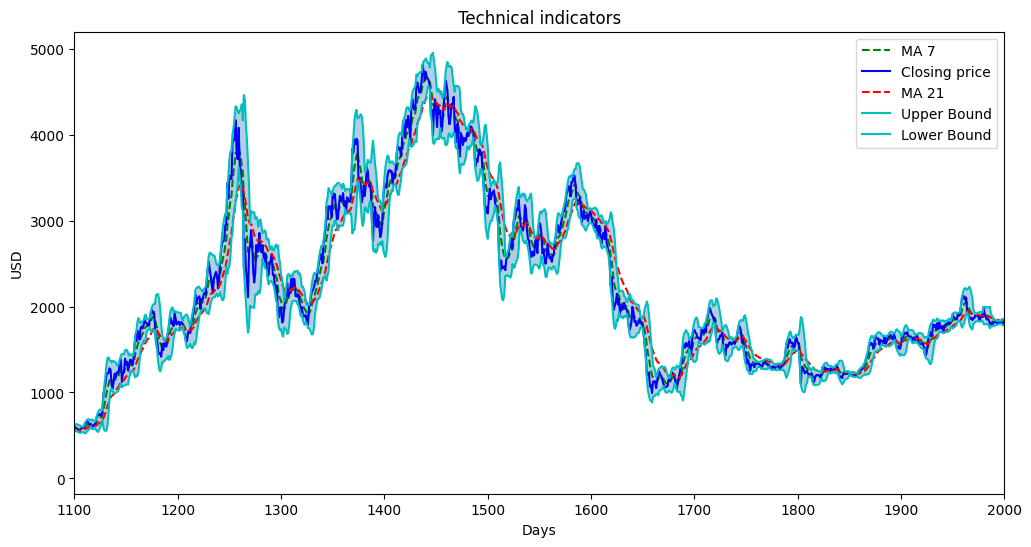

In [ ]:
x_ = np.arange(data.shape[0])

plt.figure(figsize=(12, 6))
plt.plot(data['7ma'].values, label='MA 7', color='g', linestyle='--')
plt.plot(data['Close'].values, label='Closing price', color='b')
plt.plot(data['21ma'].values, label='MA 21', color='r', linestyle='--')
plt.plot(data['7upper'].values, label='Upper Bound', color='c')
plt.plot(data['7lower'].values, label='Lower Bound', color='c')
plt.fill_between(x_, data['7lower'].values, data['7upper'].values, alpha=0.35)

# Set new x-axis and y-axis limits here to zoom in
plt.xlim(1100, 2000)

plt.title('Technical indicators')
plt.ylabel('USD')
plt.xlabel('Days')
plt.legend()
plt.show()


### Fourier Transform

Next, we apply the Fourier transform to the closing price data of the asset, demonstrating how to use the Fast Fourier Transform (FFT) for signal processing, then analyze and reconstruct the signal using a limited number of components. We then plot the original and reconstructed signals for visualization.

- `close_fft = np.fft.fft(np.asarray(data['Close'].tolist()))` computes the FFT of the closing price data, converting the time domain data into the frequency domain, which helps identify the main frequencies (or components) that make up the price movement.
- `fft_df = pd.DataFrame({'fft':close_fft})` creates a dataFrame to store the FFT results. This is augmented with columns for the absolute value and angle of each FFT component, representing the magnitude and phase of the frequencies, respectively.

<ipython-input-15-2a9e104ee532>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'FT_{num_}components'] = np.fft.ifft(fft_list_m10)
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
<ipython-input-15-2a9e104ee532>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'FT_{num_}components'] = np.fft.ifft(fft_list_m10)
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: C

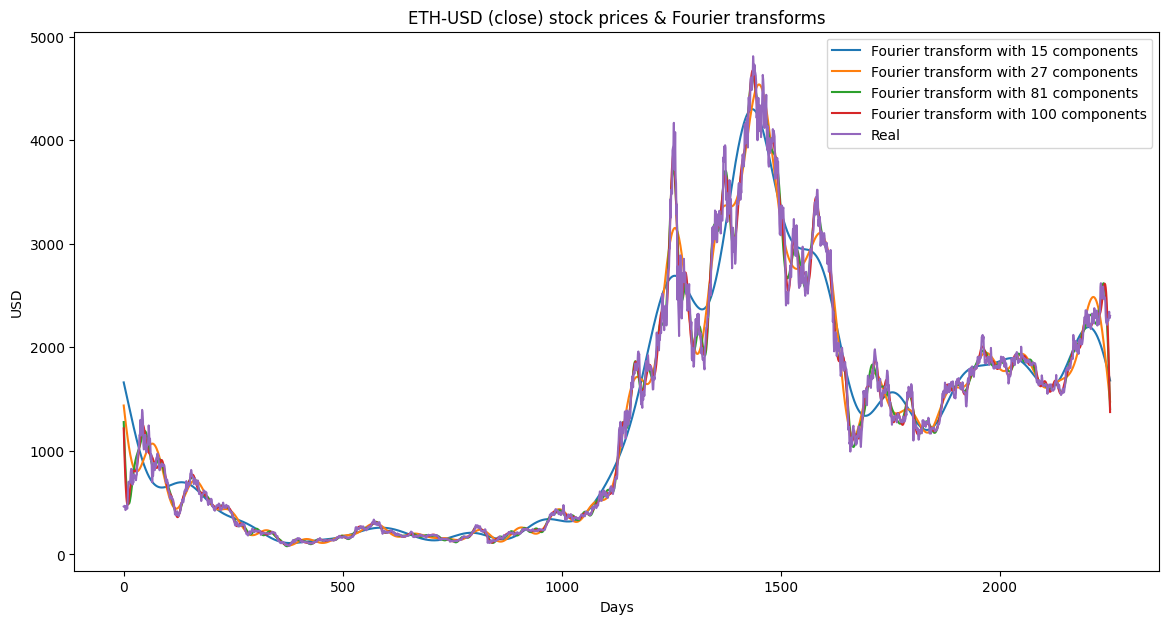

In [ ]:
close_fft = np.fft.fft(np.asarray(data['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [15, 27, 81, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_] = 0
    data[f'FT_{num_}components'] = np.fft.ifft(fft_list_m10)
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data['Close'].values,  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('ETH-USD (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

Perform a data type conversion for the columns in the DataFrame, `data`, that were added in the previous step. This ensures that these reconstructed signal columns are of type float.

In [ ]:
data['FT_15components'] = data['FT_15components'].astype('float')
data['FT_27components'] = data['FT_27components'].astype('float')
data['FT_81components'] = data['FT_81components'].astype('float')
data['FT_100components'] = data['FT_100components'].astype('float')
data.head()

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


,Open,High,Low,Close,Adj Close,Volume,Open_BTC-USD,High_BTC-USD,Low_BTC-USD,Close_BTC-USD,...,14lower,21upper,21lower,7rsv,14rsv,21rsv,FT_15components,FT_27components,FT_81components,FT_100components
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-02,466.851013,476.239014,456.653015,463.449005,463.449005,943649984,466.851013,476.239014,456.653015,463.449005,...,336.308034,523.473507,271.695738,68.000444,86.579236,90.196406,1661.696166,1438.634805,1278.581538,1217.280537
2017-12-03,463.704987,482.813995,451.851990,465.852997,465.852997,990556992,463.704987,482.813995,451.851990,465.852997,...,353.929882,527.311210,282.900417,72.550700,87.910355,91.137801,1642.976887,1400.229698,1156.734521,1067.697702
2017-12-04,466.053986,474.777008,453.312012,470.204010,470.204010,1005550016,466.053986,474.777008,453.312012,470.204010,...,371.102883,530.714364,294.115168,94.054523,91.537589,93.206898,1624.134483,1362.435965,1041.431098,930.378089
2017-12-05,470.294006,473.558014,457.660004,463.281006,463.281006,1216720000,470.294006,473.558014,457.660004,463.281006,...,396.881892,533.478013,303.318185,83.779658,82.875135,88.573987,1605.182774,1325.342855,934.400226,808.468622
2017-12-06,462.604004,462.708008,420.209991,428.588013,428.588013,1998259968,462.604004,462.708008,420.209991,428.588013,...,415.523922,531.244426,314.621392,0.000000,26.246308,65.357256,1586.135625,1289.036833,837.132505,704.413452


**Prepare the Feature Set and Target Variable**

- First, we need to select which columns in the DataFrame will serve as features and which column will be the target variable. For predicting the next day's closing price, we use technical indicators as features.

In [ ]:
# Define the target variable, e.g., next day's closing price
data['target'] = data['Close'].shift(-1)  # Create a target column for the next day's price

# Drop the last row as it will have NaN in the target column
data = data.dropna()

# Define features (all columns you want to include as predictors)
features = data.drop(columns=['target'])

<ipython-input-17-68d06247cdcd>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['target'] = data['Close'].shift(-1)  # Create a target column for the next day's price


**Split the Data into Training and Testing Sets**

- Use train_test_split from sklearn.model_selection to divide the data into training and testing sets. 80% for training and 20% for testing.

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, data['target'], test_size=0.2, random_state=42)

**Scaling Features**

- Scaling features is necessary for many machine learning algorithms.

In [ ]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Random Forest

### Default

- A Random Forest regressor is created with 100 trees (`n_estimators=100`) and a fixed `random_state` for reproducibility. The model is then trained on the training data.

In [ ]:
# Create and train the Random Forest Regression model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Evaluate the Model

In [ ]:
# Predictions
y_pred = rf_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Percentage Error:", mape)

Mean Squared Error: 6272.629935739552
R^2 Score: 0.9949451298541416
Mean Absolute Error: 39.822806654124456
Root Mean Squared Error: 79.19993646297674
Mean Absolute Percentage Error: 3.1990189518476173


Lag Scatter Plot - This shows the correlation of the current days price and the previous.

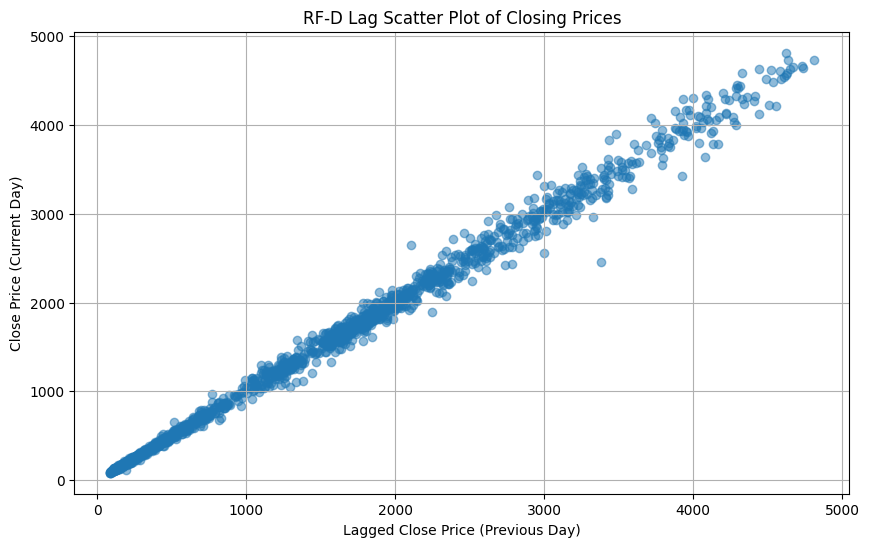

In [ ]:
data['Close_lag1'] = data['Close'].shift(1)

# Drop the NaN values that result from the lag operation
data = data.dropna()

# Creating the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['Close_lag1'], data['Close'], alpha=0.5)
plt.title('RF-D Lag Scatter Plot of Closing Prices')
plt.xlabel('Lagged Close Price (Previous Day)')
plt.ylabel('Close Price (Current Day)')
plt.grid(True)
plt.show()

Actual vs Predicted Values - Visualise the linearity between predicted and actual values of the price

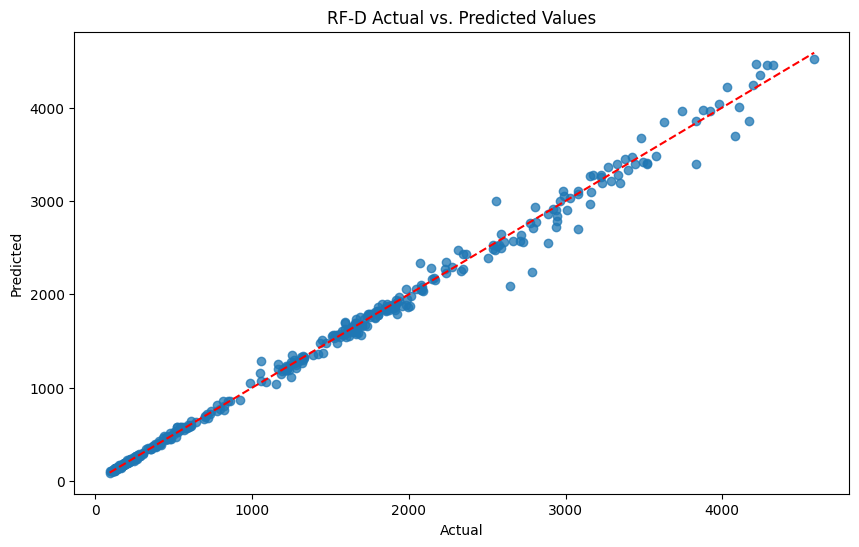

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.75)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('RF-D Actual vs. Predicted Values')
plt.show()

### Grid Search

We can use the steps taken previously up to the training/test splitting of the data and skip straight to the model training and evaluation.

We now extend this model by implementing a Grid-Search-Optimized Random Forest classifier.

**Random Forest Model Initialization with Grid Search**

A Grid Search process optimizes the Random Forest classifier by systematically exploring a range of hyperparameters, including:

- `n_estimators`: The number of trees in the forest.

- `max_depth`: The maximum depth of the trees.

- `min_samples_split`: The minimum number of samples required to split an internal node.

- `min_samples_leaf`: The minimum number of samples required to be at a leaf node.

This optimization aims to find the best combination of parameters that maximizes the model's accuracy.

**Model Training**

The optimized Random Forest model, determined by the Grid Search, is trained on the training dataset.

**Making Predictions**

This trained model is then used to predict the next day's price changes using the test dataset.

In [ ]:
# Parameters grid for GridSearchCV
param_grid = {
    'n_estimators': [50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest Regressor model
gb = RandomForestRegressor(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)

Fitting 2 folds for each of 108 candidates, totalling 216 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


In [ ]:
#Train model with optimal parameters to get training time seperate from grid search
rf_model = RandomForestRegressor(
    n_estimators=50,
    min_samples_leaf=1,
    min_samples_split=5,
    max_depth=None,
    max_features='log2',
    random_state=42
)

rf_model.fit(X_train, y_train)

RandomForestRegressor(max_features='log2', min_samples_split=5, n_estimators=50,
                      random_state=42)

Extract the best model from the search for evaluation.

In [ ]:
# Use the best estimator to make predictions
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Percentage Error:", mape)

Mean Squared Error: 5205.773156649295
R^2 Score: 0.9958048685184303
Mean Absolute Error: 38.63797739531472
Root Mean Squared Error: 72.15104404406976
Mean Absolute Percentage Error: 3.1815838458473094


Actual vs Predicted Values - Visualise the linearity between predicted and actual values of the price

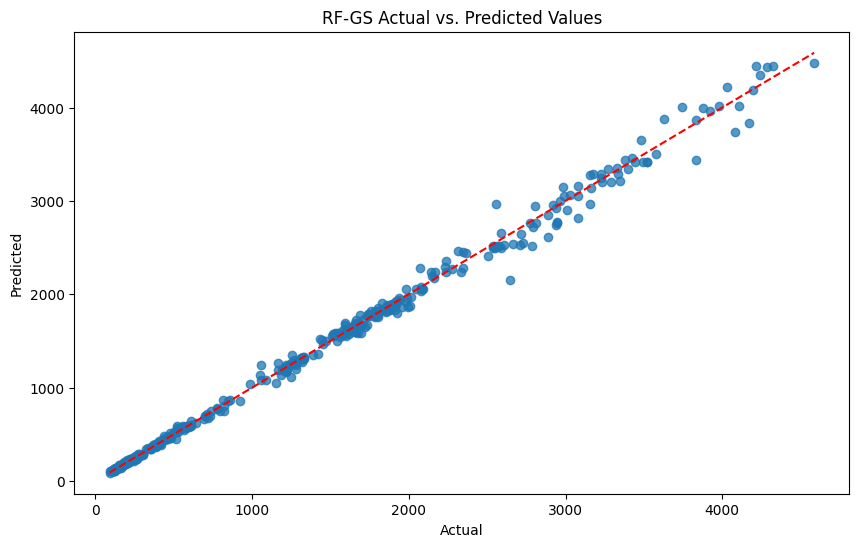

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.75)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('RF-GS Actual vs. Predicted Values')
plt.show()

## Gradient Boosting Regressor

### Default

Create and train base model with 100 estimators.

In [ ]:
# Create and train the Gradient Boosting model for regression
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

Evaluate model

In [ ]:
# Predictions
y_pred = gb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Percentage Error:", mape)

Mean Squared Error: 6513.536206873187
R^2 Score: 0.9947509927967385
Mean Absolute Error: 41.1955832121037
Root Mean Squared Error: 80.70648181449361
Mean Absolute Percentage Error: 3.560285457409709


Actual vs Predicted Values - Visualise the linearity between predicted and actual values of the price

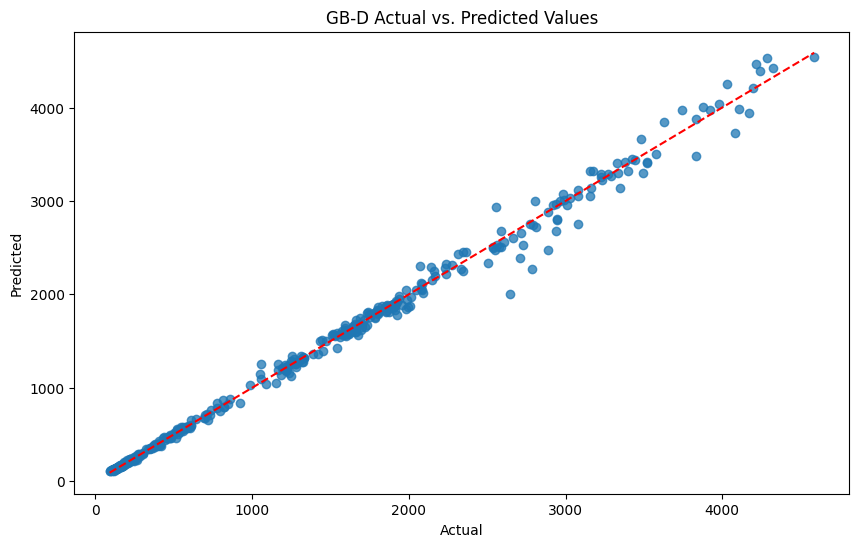

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.75)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('GB-D Actual vs. Predicted Values')
plt.show()

### Gradient Boosting with Grid Search

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [4, 6]
}

# Create the base model
gb = GradientBoostingRegressor(random_state=42)

# Setup the grid search
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=3, scoring='neg_mean_squared_error')

# Fit grid search
grid_search.fit(X_train, y_train)

# Get the best estimator
best_gb = grid_search.best_estimator_

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
# Output the best parameters and best score
print("Best parameters:", grid_search.best_params_)

Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 6, 'n_estimators': 100}


In [ ]:
y_pred = gb_model.predict(X_test)

# Calculate the error metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

# Print the error metrics
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)
print("R-squared:", r2)

Actual vs Predicted Values - Visualise the linearity between predicted and actual values of the price

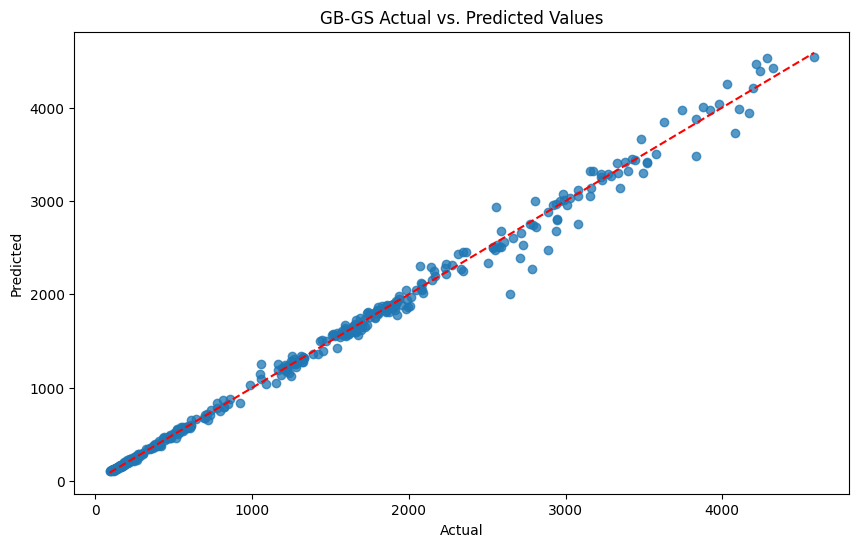

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.75)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('GB-GS Actual vs. Predicted Values')
plt.show()

## Support Vector Regressor

Create and train the model

- Parameter ranges set for the biggest impact and computational efficiency.

In [ ]:
# Configure and run grid search
param_grid = {
    'C': [0.1, 1, 5, 10, 15, 25, 50],
    'kernel': ['rbf', 'poly', 'sigmoid' ]
}
grid_search = GridSearchCV(SVR(), param_grid, refit=True, verbose=2, cv=2)
grid_search.fit(X_train, y_train)

# Output best parameters
print("Best parameters found: ", grid_search.best_params_)

Fitting 2 folds for each of 21 candidates, totalling 42 fits
[CV] END ..................................C=0.1, kernel=rbf; total time=   1.5s
[CV] END ..................................C=0.1, kernel=rbf; total time=   1.6s
[CV] END .................................C=0.1, kernel=poly; total time=   0.9s
[CV] END .................................C=0.1, kernel=poly; total time=   0.8s
[CV] END ..............................C=0.1, kernel=sigmoid; total time=   0.9s
[CV] END ..............................C=0.1, kernel=sigmoid; total time=   1.0s
[CV] END ....................................C=1, kernel=rbf; total time=   1.2s
[CV] END ....................................C=1, kernel=rbf; total time=   2.0s
[CV] END ...................................C=1, kernel=poly; total time=   1.3s
[CV] END ...................................C=1, kernel=poly; total time=   1.0s
[CV] END ................................C=1, kernel=sigmoid; total time=   0.9s
[CV] END ................................C=1, ke

Evaluate the model.

In [ ]:
# Prediction and evaluation
y_pred = grid_search.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) /y_test))*100
print("Mean Absolute Percentage Error: ", mape, "%")

Mean Squared Error: 45464.47089899136
Root Mean Squared Error: 213.2239923155726
Mean Absolute Error: 92.77962090108998
R^2 Score: 0.9633619392505323
Mean Absolute Percentage Error:  18.158616636870182 %


Actual vs Predicted Values - Visualise the linearity between predicted and actual values of the price

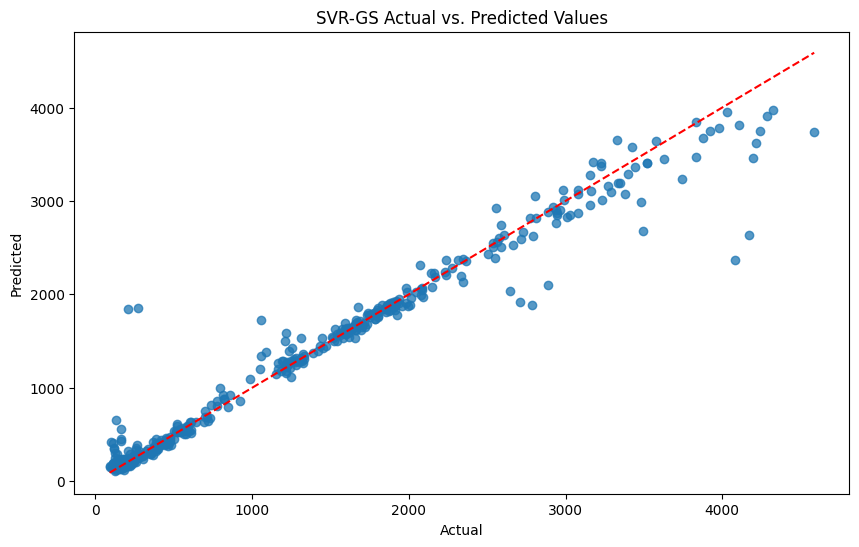

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.75)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('SVR-GS Actual vs. Predicted Values')
plt.show()

## Prepare the dataset for machine learning models

**Prep**
  - `data['y'] = data['Close']` creates a copy of 'Close' column to isolate the target variable for prediction.

**Splitting**
  - `(split = int(data.shape[0] * 0.8))` splits the dataset into training and testing sets using an 80-20 split.
  - `train_x`, `test_x` and `train_y`, `test_y` are defined by slicing the x and y arrays according to the split index, separating the data into parts used for training and testing the model, respectively.

**Scaling**
  - MinMaxScaler is used to scale both the features (`train_x, test_x`) and the target variable (`train_y, test_y`) to a range between 0 and 1.
  - Scaling is crucial for the machine learning algorithms to perform well, and ensures all features contribute equally to the model's learning process.
  - The scalers are fit on the training data, then applied to both the training and testing sets so the model is not biased by information in the test set.

In [ ]:
# 'data' is the DataFrame that contains the 'Close' prices and other features

# Create the target column for next day's price prediction
data['y'] = data['Close'].shift(-1)
data.dropna(inplace=True)  # Ensure to drop the last row which now includes NaN in the target column

# Select features and target
X = data.drop(['y'], axis=1).values  # All other columns as features
y = data['y'].values  # Target is the next day's close price

# Splitting the data into training and testing sets
split = int(data.shape[0] * 0.8)
train_x, test_x = X[:split, :], X[split:, :]
train_y, test_y = y[:split], y[split:]

# Scaling the features and target
x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

# Output the shapes of the datasets
print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

trainX: (1800, 781) trainY: (1800, 1)
testX: (451, 781) testY: (451, 1)


<ipython-input-23-c8531b09b080>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['y'] = data['Close'].shift(-1)


**Sequencing the data.**

Method for preparing time series data into sequences for training sequence-based neural networks  followed by reshaping the data for the specific input structure required by these models.

In [ ]:
import numpy as np

def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(data)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data[i:end_ix, :-1], data[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Size of lookback (window size) reducing this can increase performance but the model is prone to learning the previous price as the best prediction.
n_steps = 20
n_features = train_x.shape[1]

# Prepare the training and testing data
train_data = np.column_stack((train_x, train_y))
test_data = np.column_stack((test_x, test_y))

train_x_seq, train_y_seq = create_sequences(train_data, n_steps)
test_x_seq, test_y_seq = create_sequences(test_data, n_steps)

# Reshape data for CNN-LSTM
subsequences = 2
timesteps = n_steps // subsequences
train_x_seq_reshaped = train_x_seq.reshape((train_x_seq.shape[0], subsequences, timesteps, n_features))
test_x_seq_reshaped = test_x_seq.reshape((test_x_seq.shape[0], subsequences, timesteps, n_features))

## CNN BiLSTM

Build model, change log can be found in Appendix E for a breakdown of the iterations taken to get to presented model.

In [ ]:
# Reshape data for the new model
train_x_seq_reshaped = train_x_seq.reshape((train_x_seq.shape[0], n_steps, n_features))
test_x_seq_reshaped = test_x_seq.reshape((test_x_seq.shape[0], n_steps, n_features))

input_layer = Input(shape=(n_steps, n_features))

# CNN layer
conv1 = Conv1D(filters=16, kernel_size=3, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(input_layer)
batch_norm1 = BatchNormalization()(conv1)
pool1 = MaxPooling1D(pool_size=2)(batch_norm1)
drop1 = Dropout(0.25)(pool1)

# LSTM layer
lstm1 = Bidirectional(LSTM(50, return_sequences=True, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))(drop1)
batch_norm2 = BatchNormalization()(lstm1)
drop2 = Dropout(0.25)(batch_norm2)

# Attention layer
attention = Attention()([drop2, drop2])

# Flatten the output after attention layer
flat2 = Flatten()(attention)

# Fully connected layers
dense1 = Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(flat2)
dropout_final = Dropout(0.25)(dense1)
dense2 = Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(dropout_final)
output_layer = Dense(1)(dense2)

# Create model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(optimizer='adam', loss='mse')

# Callbacks
checkpoint = ModelCheckpoint('model_best.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min', min_lr=0.0001)

callbacks_list = [checkpoint, early_stopping, reduce_lr]

# Fit model
history = model.fit(train_x_seq_reshaped, train_y_seq, epochs=100, batch_size=32,
                    validation_data=(test_x_seq_reshaped, test_y_seq),
                    verbose=2, callbacks=callbacks_list)


Epoch 1/100

Epoch 1: val_loss improved from inf to 0.06947, saving model to model_best.h5
56/56 - 11s - loss: 0.2605 - val_loss: 0.0695 - lr: 0.0010 - 11s/epoch - 199ms/step
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 0.06947
56/56 - 2s - loss: 0.0639 - val_loss: 0.0773 - lr: 0.0010 - 2s/epoch - 27ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.06947 to 0.05541, saving model to model_best.h5
56/56 - 2s - loss: 0.0512 - val_loss: 0.0554 - lr: 0.0010 - 2s/epoch - 28ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.05541 to 0.05187, saving model to model_best.h5
56/56 - 2s - loss: 0.0465 - val_loss: 0.0519 - lr: 0.0010 - 2s/epoch - 28ms/step
Epoch 5/100

Epoch 5: val_loss improved from 0.05187 to 0.04636, saving model to model_best.h5
56/56 - 2s - loss: 0.0467 - val_loss: 0.0464 - lr: 0.0010 - 2s/epoch - 28ms/step
Epoch 6/100

Epoch 6: val_loss did not improve from 0.04636
56/56 - 2s - loss: 0.0446 - val_loss: 0.0471 - lr: 0.0010 - 2s/epoch - 28ms/step
Epoch 7/100

Epoch 7: val_loss improved from 0.04636 to 0.03662, saving model to model_best.h5
56/56 - 3s - loss: 0.0458 - val_loss: 0.0366 - lr: 0.0010 - 3s/epoch - 47ms/step
Epoch 8/100

Epoch 8: val_

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 20, 781)]            0         []                            
                                                                                                  
 conv1d_1 (Conv1D)           (None, 18, 16)               37504     ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 18, 16)               64        ['conv1d_1[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 max_pooling1d_1 (MaxPoolin  (None, 9, 16)                0         ['batch_normalization[0][0

### Evaluation

In [ ]:
# Evaluate the model on the training data
train_loss = model.evaluate(train_x_seq_reshaped, train_y_seq, verbose=0)

# Evaluate the model on the testing data
test_loss = model.evaluate(test_x_seq_reshaped, test_y_seq, verbose=0)

print(f"Training Loss: {train_loss:.4f}")
print(f"Testing Loss: {test_loss:.4f}")


Training Loss: 0.0110
Testing Loss: 0.0073


Plot learning curve to assess training. Large spikes
indicate overfitting.

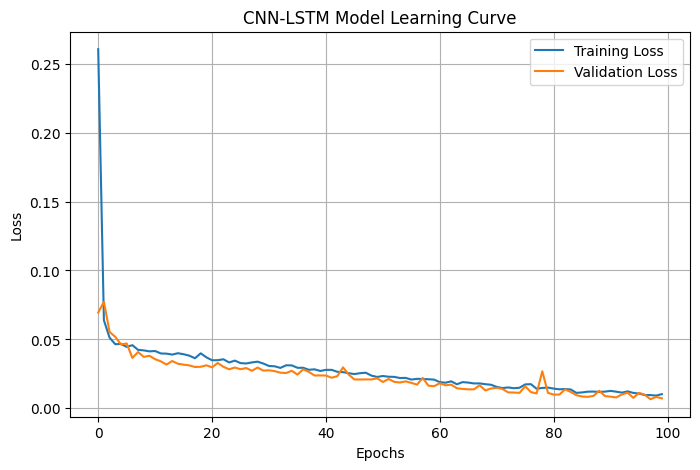

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN-LSTM Model Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Generate predictions
predicted_prices = model.predict(test_x_seq_reshaped)
actual_prices = test_y_seq

# Inverse transform the predicted and actual prices if they were scaled
predicted_prices = y_scaler.inverse_transform(predicted_prices)
actual_prices = y_scaler.inverse_transform(actual_prices.reshape(-1, 1))

# Calculate the direction of the predicted and actual prices
predicted_direction = np.sign(np.diff(predicted_prices, axis=0))
actual_direction = np.sign(np.diff(actual_prices, axis=0))

# Calculate accuracy
correct_predictions = np.sum(predicted_direction == actual_direction)
total_predictions = len(predicted_direction)
accuracy = correct_predictions / total_predictions

print(f"Directional Accuracy: {accuracy:.2f}")


14/14 [==============================] - 0s 6ms/step
Directional Accuracy: 0.52


Evaluate metrics

In [ ]:
# MSE
mse = mean_squared_error(actual_prices, predicted_prices)
r2 = r2_score(actual_prices, predicted_prices)
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100
mae = mean_absolute_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")
print(f"R2 Score: {r2}")
print(f"RMSE: {rmse}")

MSE: 39693.10916252375
MAE: 174.69920175645302
MAPE: 10.33071729057096%
R2 Score: 0.566453320319743
RMSE: 199.23129564032794


In [ ]:
daily_returns = np.diff(actual_prices, axis=0) / actual_prices[:-1]
risk_free_rate = 0.01 / 365  # Annualized risk-free rate divided by the number of trading days in a year

# Calculate excess returns
excess_returns = daily_returns - risk_free_rate

# Calculate Sharpe Ratio
sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)

print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Sharpe Ratio: 0.07


## AutoML H20

Standard H2O set up. H2O.ai contains all the documentation for customising this model.

In [ ]:
# Initialize H2O cluster
h2o.init()  # Adjust memory size as necessary

# Convert the DataFrame to an H2OFrame
h2o_df = h2o.H2OFrame(data)

# Split the data: 70% training, 15% validation, 15% test
train, valid, test = h2o_df.split_frame(ratios=[0.7, 0.15], seed=123)

# Define features and target
# Assuming all columns except 'Close' are features, and 'Close' is the target.
features = h2o_df.columns
features.remove('Close')
target = 'Close'

# Run AutoML for 20 base models, limited by max runtime and seed for reproducibility
aml = H2OAutoML(max_models=20, seed=1, max_runtime_secs=3600)
aml.train(x=features, y=target, training_frame=train, validation_frame=valid)

# View the AutoML Leaderboard
print(aml.leaderboard)

# Predict on the test set
preds = aml.leader.predict(test)

# Calculate performance on the test set
performance = aml.leader.model_performance(test)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmplvx_mv9l
  JVM stdout: /tmp/tmplvx_mv9l/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmplvx_mv9l/h2o_unknownUser_started_from_python.err


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 22 days
H2O_cluster_name:,H2O_from_python_unknownUser_1xlvbs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
15:25:27.107: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                    rmse      mse      mae       rmsle    mean_residual_deviance
GBM_5_AutoML_1_20240505_152527                           4.98767  24.8769  2.13939  0.00452134                   24.8769
StackedEnsemble_AllModels_1_AutoML_1_20240505_152527     5.07006  25.7055  2.11763  0.00441296                   25.7055
StackedEnsemble_BestOfFamily_1_AutoML_1_20240505_152527  5.47924  30.0221  2.16705  0.0043824                    30.0221
GBM_4_AutoML_1_20240505_152527                      

Extract the best model details.

In [ ]:
# Accessing the best model
best_model = aml.leader

print(best_model)

Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_5_AutoML_1_20240505_152527


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    90                 90                          73455                  6            6            6             42            64            60.3444

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.19150519889286421
RMSE: 0.4376130698378011
MAE: 0.3334821626487626
RMSLE: 0.001372880530628779
Mean Residual Deviance: 0.19150519889286421

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 20.470966455268513
RMSE: 4.524485214393844
MAE: 1.8690673197924497
RMSLE: 0.003431845384695304
Mean Residual Deviance: 20.47096645526

In [ ]:
# Detailed view of H2O model parameters
for param in model_params:
    print(f"{param}: {model_params[param]['actual']}")

model_id: {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'GBM_5_AutoML_1_20240505_152527', 'type': 'Key<Model>', 'URL': '/3/Models/GBM_5_AutoML_1_20240505_152527'}
training_frame: {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20240505_152527_training_py_2_sid_bd71', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20240505_152527_training_py_2_sid_bd71'}
validation_frame: {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'py_3_sid_bd71', 'type': 'Key<Frame>', 'URL': '/3/Frames/py_3_sid_bd71'}
nfolds: 5
keep_cross_validation_models: False
keep_cross_validation_predictions: True
keep_cross_validation_fold_assignment: False
score_each_iteration: False
score_tree_interval: 5
fold_assignment: Modulo
fold_column: None
response_column: {'__meta': {'schema_version': 3, 'schema_name': 'ColSpecifierV3', 'schema_type': 'VecSpecifier

Evaluate metrics.

In [ ]:
# Calculate performance on the test set
metrics = aml.leader.model_performance(test)

# Print out performance metrics for the model
print("MSE:", performance.mse())
print("RMSE:", performance.rmse())
print("MAE:", performance.mae())
print("R^2:", performance.r2())

MSE: 11.693410691279642
RMSE: 3.419562938634065
MAE: 1.648993887232749
R^2: 0.999989599355884


Extract most useful features.

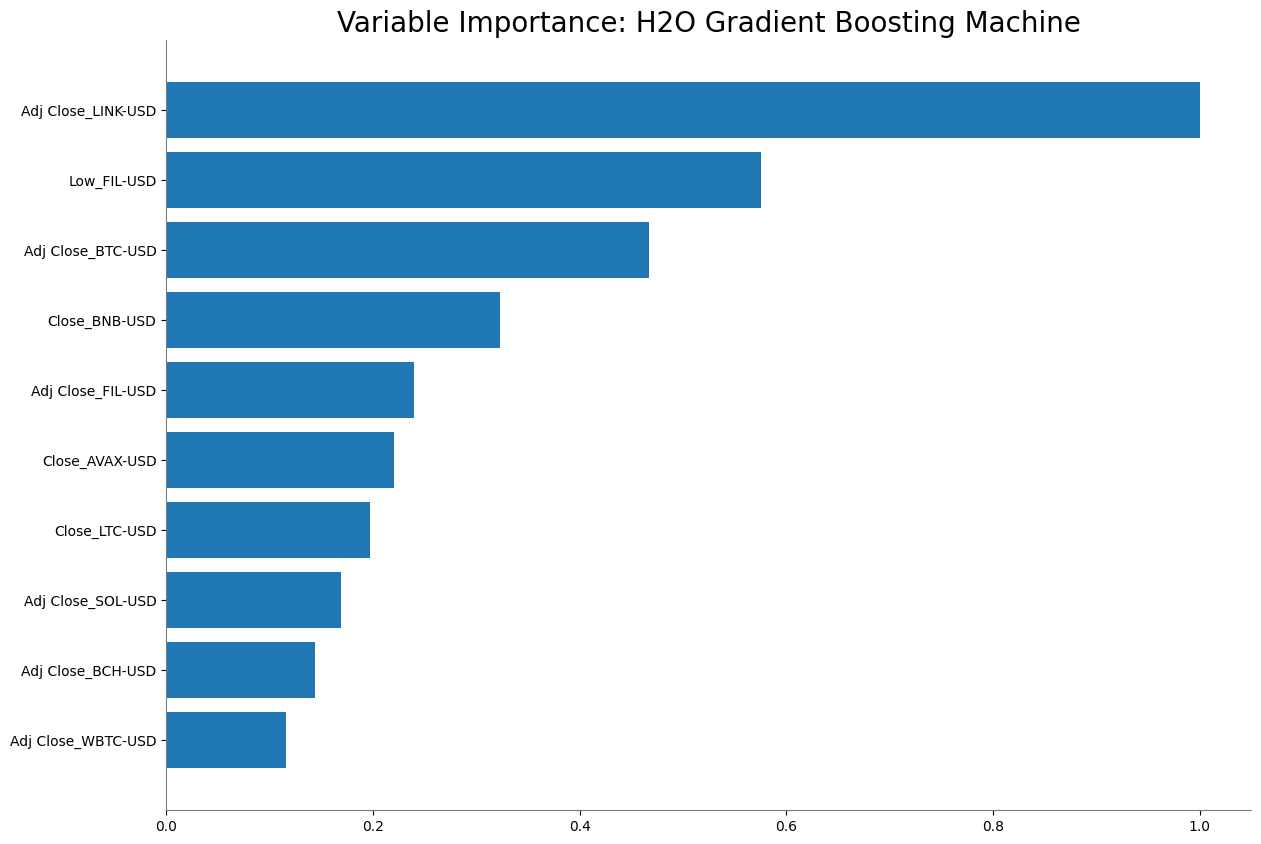

<Figure size 640x480 with 0 Axes>

In [ ]:
aml.leader.varimp_plot()


Plot actual versus predicted prices for model selected by H2O AutoML.

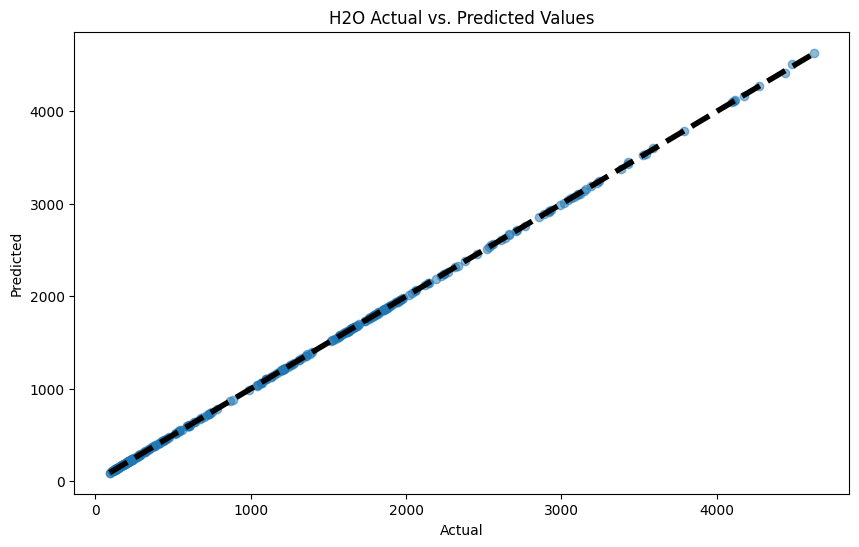

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'k--', lw=4)  # Line for perfect predictions
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('H2O Actual vs. Predicted Values')
plt.show()

Visualise Predictions versus actual prices.

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O f

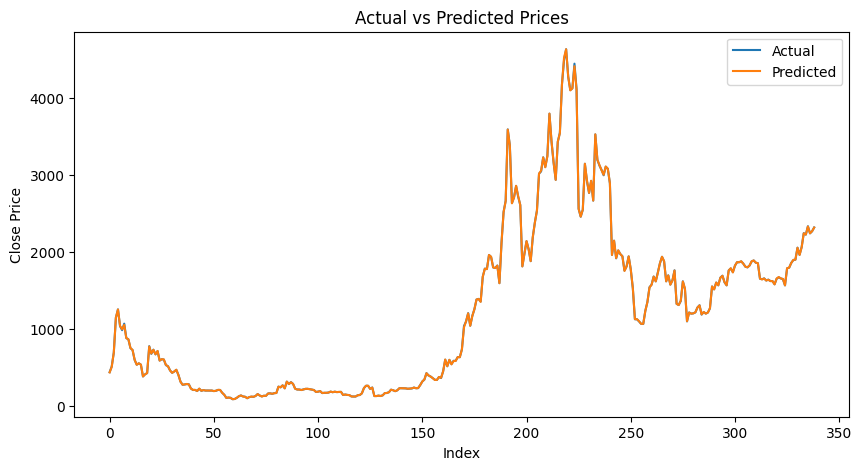

In [ ]:
import matplotlib.pyplot as plt

# Convert H2OFrame to Pandas DataFrame for plotting
preds_df = preds.as_data_frame()  # Predictions to DataFrame
test_actuals = test.as_data_frame()[target]  # Extract actual values for the target from the test set

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(test_actuals.reset_index(drop=True), label='Actual')
plt.plot(preds_df['predict'].reset_index(drop=True), label='Predicted')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

Focused plot as above.

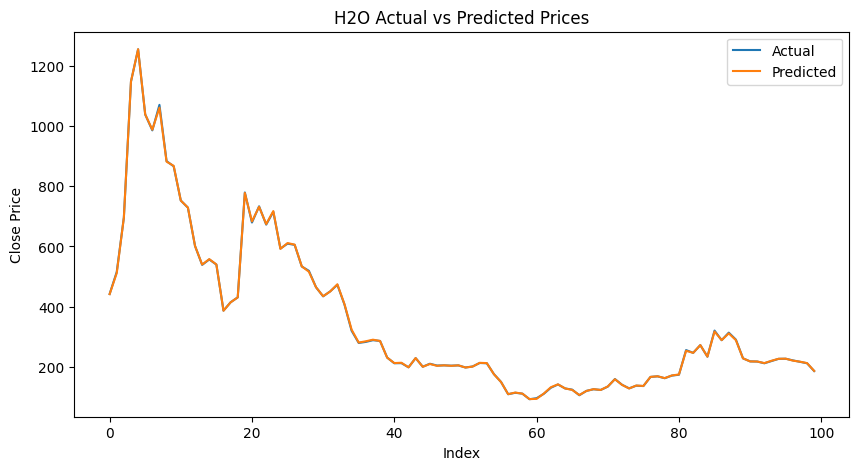

In [ ]:
# Focused plot
plt.figure(figsize=(10, 5))
plt.plot(test_actuals.reset_index(drop=True)[:100], label='Actual')  # Focus on the first 100 points
plt.plot(preds_df['predict'].reset_index(drop=True)[:100], label='Predicted')  # Focus on the first 100 points
plt.title('H2O Actual vs Predicted Prices')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()